# Assignment 10

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).

---

#### ``Objectives``
1. Implement a CNN to detect diabetic retinopathy (DR) from retina images taken using fundus photography under a variety of imaging conditions.
2. Improve generalization performance and reduce overfitting using **image transformation** and **data augmentation** techniques.

#### ``Motivation``

Diabetic retinopathy (DR) is an eye condition that  affects blood vessels in the retina. It can cause vision loss and blindness in people who have diabetes. Screening for DR allows earlier and more effective treatment options for millions of people.

#### ``Data``

In this assignment you will use a small dataset of retina images (`Download` links: [images](https://drive.google.com/drive/folders/1sdfUC64Un1iwuiHEehcbijxB54OhU_nd?usp=sharing) and [labels](https://drive.google.com/drive/folders/1MOlSJBZg7L1HtG5vHPt77ighRvQaGfDg?usp=sharing)). You will **build** and **train** a **CNN model** to predict whether or not to refer a patient for DR treatment using binarized severity of DR in patients: no referral if {No DR, mild} and referral if {moderate, severe, and proliferate DR}.


<u>Note</u>: the original dataset is hosted by Kaggle [[Source]](https://www.kaggle.com/c/aptos2019-blindness-detection/).

Import the necessary libraries and make sure to replace IMAGE_PATH and LABEL_PATH with the path to the directories where you saved the data.

---
### Step 1: Import libraries

In [18]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

# sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# plots
import seaborn as sns
import matplotlib.pyplot as plt

random.seed(2)
%matplotlib inline

# FILL IN CODE HERE #
IMAGE_PATH = './cnn/CNN_images-20241112T010231Z-001/CNN_images/' # replace with your path
LABEL_PATH = './cnn/' # replace with your path

At this point, you may ask yourself what the best model that fits this data is. First, you will want to read through the data description in Kaggle (see the link to the original dataset above). Understanding what you are working with challenges you to write preprocessing code that uncovers your data's most helpful information.

---
#### <span style="color:chocolate"> Exercise 1 (10 points) </span>

Read the data description from Kaggle and list (a) the source of images and (b) the labeling procedure.

*Written answer*:

Source of Images:
The images are retinal fundus photographs collected from patients. Fundus photography captures detailed images of the retina, allowing clinicians to observe any abnormalities related to diabetic retinopathy. These images were acquired under various imaging conditions and display a range of lighting, focus, and contrast.

Labeling Procedure:
The dataset labels each image according to the severity of diabetic retinopathy, determined by medical experts. The levels are defined as follows:
0 - No DR (No Diabetic Retinopathy)
1 - Mild DR
2 - Moderate DR
3 - Severe DR
4 - Proliferative DR (advanced stage with high risk of vision loss)

For this assignment, labels are binarized to simplify classification:
No referral for severity levels 0 and 1
Referral for severity levels 2, 3, and 4

---
### Step 2: Data ingestion

Let's load the 2D images and their corresponding labels.

``labels``

In [7]:
labels = pd.read_csv(
    LABEL_PATH + 'labels.csv'
)

print('Shape of labels:', labels.shape)
print('Unique diagnosis codes:', np.sort(labels.diagnosis.unique()))
labels.head()

Shape of labels: (200, 2)
Unique diagnosis codes: [0 1 2 3 4]


,id_code,diagnosis
0,000c1434d8d7,2
1,0024cdab0c1e,1
2,0083ee8054ee,4
3,00a8624548a9,2
4,00b74780d31d,2


There are 200 training images corrresponding to 5 different diabetic retinopathy (DR) diagnosis codes: 

* No DR (0)
* mild (1)
* moderate (2)
* severe (3)
* proliferate DR (4)


``images``

In [19]:
images = []

for idx, img in enumerate(os.listdir(IMAGE_PATH)):
    img = load_img(
    IMAGE_PATH + img)
    images.append(img)

---
### Step 3: Exploratory Data Analysis (EDA)

#### <span style="color:chocolate"> Exercise 2 (10 points) </span>

Plot a histogram for the five classes of DR. Are the classes balanced?


Note: It's acceptable to plot the distribution of classes before splitting your data into training, validation, and test sets. Doing so does not compromise the "blindness" of the test data. Why?

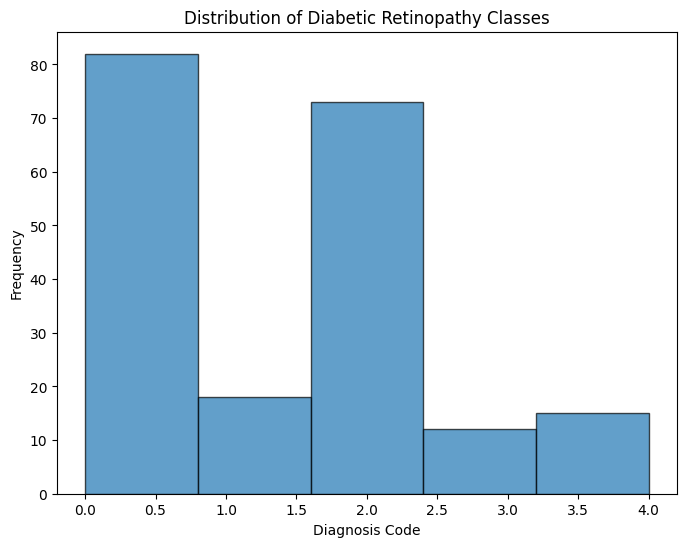

In [22]:
# YOUR CODE HERE
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
import os

# Plot histogram for the five classes of DR
plt.figure(figsize=(8, 6))
plt.hist(labels['diagnosis'], bins=5, edgecolor='k', alpha=0.7)
plt.title("Distribution of Diabetic Retinopathy Classes")
plt.xlabel("Diagnosis Code")
plt.ylabel("Frequency")
plt.show()

Comment on class balance: [YOUR ANSWER HERE].

No, the histogram shows that the classes are not balanced. Specifically:

The 0 and 2 classes (No DR and Moderate DR) have a high frequency compared to the other classes.
The 1, 3, and 4 classes (Mild, Severe, and Proliferative DR) have significantly fewer samples.

#### <span style="color:chocolate"> Exercise 3 (10 points) </span>

Print 8 images from the data. What can you say about the size, focus/orientation of these images?

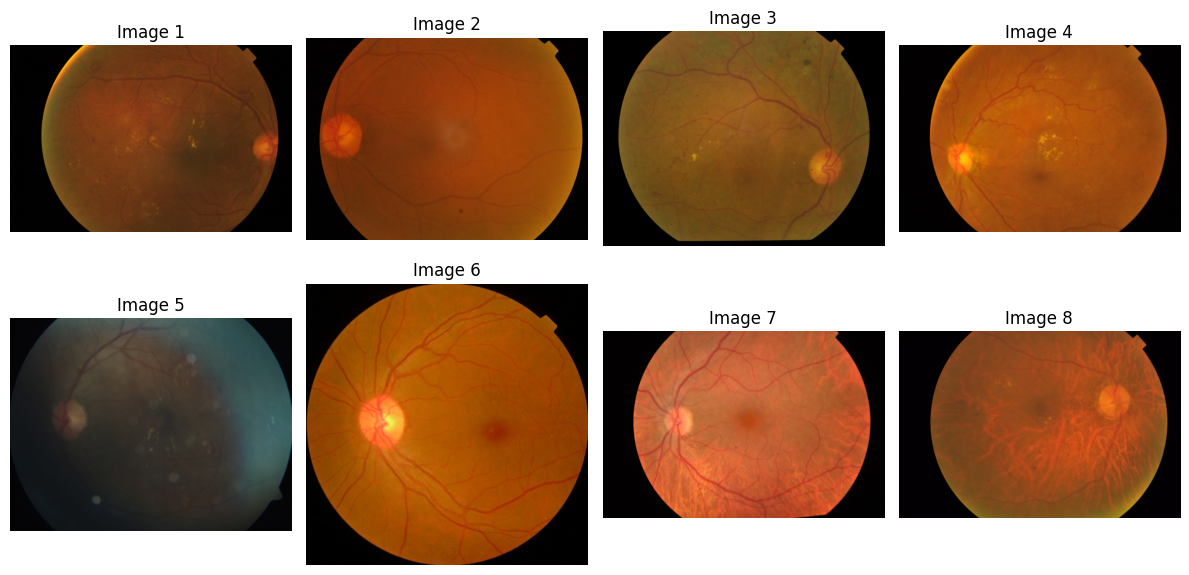

In [24]:
# FILL IN CODE HERE #
from PIL import Image

# Function to display a sample of 8 images
def display_images(image_path, num_images=8):
    images = os.listdir(image_path)[:num_images]
    plt.figure(figsize=(12, 6))
    
    for i, img_name in enumerate(images):
        img = Image.open(os.path.join(image_path, img_name))
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Image {i+1}")
        
    plt.tight_layout()
    plt.show()

# Display 8 images
display_images(IMAGE_PATH)

Comment on the size, focus/orientation of the 8 images: [YOUR ANSWER HERE]

Size: The images appear to be relatively large and have a circular region of interest (the retina) centered within a black background. The actual resolution of these images may vary depending on the device that captured them, but they generally contain sufficient detail for observing the retinal features.

Focus: The images exhibit varying levels of focus. Some images are sharper, showing clear blood vessels and retinal details (like images 6 and 7), while others are blurrier, which could make it challenging for a model to identify detailed features (like image 5). Differences in focus might be due to the patient's movement, imaging conditions, or device quality.

Orientation: The orientation of the retina is generally consistent, with the optic disc (the bright circular spot) usually located to one side. However, there may be slight variations in rotation, which is typical in medical imaging. Consistent orientation helps the model, but minor rotations can be addressed through data augmentation techniques.

---
### Step 4: Data preprocessing

First, we will correct for class imbalance. Note that imbalanced data is common in healthcare, and it happens because some diseases are rare. The presence of imbalanced data hampers the detection of rare events as most classification methods implicitly assume a similar occurrence of classes and are designed to maximize the overall classification accuracy.

We will correct for class imbalance in two ways:

  * First, we will binarize the DR diagnosis as follows:
     - 'no refer' are {No DR, mild}
     - 'refer' are {Moderate, Severe, Proliferate}


  * Second, we'll only take 80 random samples from the 'no refer' class and 80 from the 'refer' class.

It is a crude method to deal with imbalanced data, but it will be good enough for this homework. 

In [25]:
np.random.seed(1234)

no_refer = labels[labels.diagnosis.isin((0,1))]
refer = labels[labels.diagnosis.isin((2,3,4))]

# randomly draw 80 images from each classes
temp_no_refer = list(np.random.choice(
    no_refer.id_code,
    size=80,
    replace=False
))

temp_refer = list(np.random.choice(
    refer.id_code,
    size=80,
    replace=False
))

Next, we will use the ``preprocess_data_part1()`` function defined below to generate lists of images and labels (images_mini and y_mini) based on the values in the temp_no_refer and temp_refer lists. Note that the size of the image is set to (224, 224).

In [26]:
def preprocess_data_part1(IMAGE_PATH, LABEL_PATH, temp_no_refer, temp_refer):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    LABEL_PATH (str): path to directory with labels.
    temp_no_refer (str): list of labels for the no refer category
    temp_refer (str): list of labels for the refer category
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 224, 224, 3)
    y_mini (np.ndarray): Labels of shape (N,)    
    """
    y_mini = []
    images_mini = []

    # create lists of images and labels `images_mini` and `y_mini` 
    # based on temp_no_refer and temp_refer selections
    for idx, img in enumerate(os.listdir(IMAGE_PATH)):
        # read labels
        if img.split('.')[0] in temp_no_refer:
                y_mini.append(0)
        elif img.split('.')[0] in temp_refer:
                y_mini.append(1)
        else:
            continue

        
        # read image
        img = load_img(
            IMAGE_PATH + img,
            target_size=(224, 224)
        )
        
        # transform image to array
        img = img_to_array(img)

        # append to images
        images_mini.append(img)

    # stack images and trasnform to array
    images_mini = np.stack(images_mini)
    y_mini = np.array(y_mini).flatten() 
    
    return images_mini, y_mini

In [27]:
# generate images and labels based on preprocess_data_part1() function
images_mini, y_mini = preprocess_data_part1(
    IMAGE_PATH, LABEL_PATH, temp_no_refer, temp_refer
)

print(f"images_mini shape {images_mini.shape}")
print(f"y_mini shape {y_mini.shape}")

images_mini shape (160, 224, 224, 3)
y_mini shape (160,)


#### <span style="color:chocolate"> Exercise 4 (20 points) </span>

Create train, validation, and test data. Implement the `preprocess_data_part2()` function according to the following guidelines:

1. shuffle images and labels before splitting the data

2. use a (0.6,0.2,0.2)train/validation/test set split

3. perform image transformation and augmentation, as follows:
    * Applied on training set only:
         - create additional copies (augmentations) of the training images by flipping left right each image (Hint: use the method available in the tf.image module).
         - concatenate the augmented images to the original training images. Note that the train set should be double in size after data augmentation, i.e., 192 images and labels.
    * Applied on training, validation, and test sets:
        - rescale images by dividing each pixel by 255.0

Reason for doing image augmentation: The quantity and diversity of data gathered significantly impact the results of a CNN model. One can use augmentations to artificially inflate the training dataset by warping the original data so that their label does not change. These augmentations can significantly improve learning results without collecting new data.

In [28]:
def preprocess_data_part2(images, labels, splits):
    """ Split data into train, validation and test sets; apply transformaions and augmentations
    
    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)
    labels (np.ndarray): Labels of shape (N,)   
    splits (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    """
    
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator 
    tf.random.set_seed(1234)
    np.random.seed(1234)
    
    # shuffle data
    # FILL IN CODE HERE #
    indices = np.arange(len(images))
    np.random.shuffle(indices)
    images = images[indices]
    labels = labels[indices]
    
    # create data splits (training, val, and test sets)
    # FILL IN CODE HERE #
    # Split data into train, validation, and test sets based on the given split ratios
    n_total = len(images)
    n_train = int(n_total * splits[0])
    n_val = int(n_total * splits[1])
    
    X_train, y_train = images[:n_train], labels[:n_train]
    X_val, y_val = images[n_train:n_train + n_val], labels[n_train:n_train + n_val]
    X_test, y_test = images[n_train + n_val:], labels[n_train + n_val:]
    
    # image augmentation (random flip) on training data
    X_train_augm = tf.image.flip_left_right(X_train)

    # concatenate original X_train and augmented X_train_augm data
    X_train = np.concatenate([X_train, X_train_augm], axis=0)

    # concatenate y_train (note the label is preserved)
    y_train_augm = y_train
    y_train = np.concatenate([y_train, y_train_augm], axis=0)

    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle).numpy() # transform X back to numpy array instead of tensor
    y_train = tf.gather(y_train, shuffle).numpy() # transform y back to numpy array instead of tensor

    # rescale training, val, and test images by dividing each pixel by 255.0 
    # FILL IN CODE HERE #
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [29]:
# define splits
split = (0.6, 0.2, 0.2)

X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_mini,
    y_mini,
    split
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (192, 224, 224, 3)
y_train shape (192,)
X_val shape (32, 224, 224, 3)
y_val shape (32,)
X_test shape (32, 224, 224, 3)
y_test shape (32,)


---
### Step 5: Modeling

#### <span style="color:chocolate"> Exercise 5 (20 points) </span>

The objective is to build and train a CNN model to refer patients to doctors based on the severity of DR seen in these images. You are interested in exploring binary classification of 'no refer' and 'refer'.

Implement a CNN classifier according to the following guidelines (let's call this *model_tf*):

1. Implement this model using the TF Keras API.
1. The model receives input images of size 224 x 224 x 3 (that is, the images have three color channels)
2. The input data goes through one convolutional layer that has the following specifications:
    - filters = 12
    - kernel_size = (4 x 4)
    - strides = (1, 1)
    - padding = 'same'
    - data_format = 'channels_last'
    - name = 'conv_1'
    - activation = 'relu'
3. The convolutional layer is followed by a max-pooling layer with pool_size = (2,2). Note: this will reduce the size of the feature maps.
4. The max-pooling layer is followed by a dropout layer with rate = 0.3.
5. The dropout layer is followed by a flattening layer.
6. The last layer of the model is the classification head.
7. Build and compile the model using the Adam optimizer and learning_rate = 0.1. Print summary of the model.
8. Train the model on (X_train, y_train) data for 20 epochs. Add early stopping (Hint: pass the early_stopping implementation below to the fit() method as "callbacks=[early_stopping]").
9. How many parameters does the model have?
10. Generate a plot (for the training and validation data) with the loss values on the y-axis and the epoch number on the x-axis for visualization. Make sure to include axes name and title. Hint: check what the tf.keras.Model.fit() method returns.
11. Evaluate the accuracy of the model on (X_train, y_train) and (X_val, y_val) data. Comment on model performance on training vs. validation datasets. 

In [30]:
# define an instance of the early_stopping class
early_stopping = tf.keras.callbacks.EarlyStopping(
monitor='accuracy', 
verbose=1,
patience=5,
mode='max',
restore_best_weights=True)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 224, 224, 12)   │           588 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 112, 112, 12)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 112, 112, 12)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │       150,529 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,117 (590.30 KB)

 Trainable params: 151,117 (590.30 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.5446 - loss: 2553.1938 - val_accuracy: 0.5625 - val_loss: 0.6751
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6143 - loss: 0.6516 - val_accuracy: 0.7188 - val_loss: 0.9029
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6818 - loss: 0.5460 - val_accuracy: 0.7500 - val_loss: 3.4235
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7136 - loss: 0.7120 - val_accuracy: 0.7812 - val_loss: 6.6688
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7679 - loss: 0.4736 - val_accuracy: 0.8125 - val_loss: 8.9785
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7958 - loss: 0.4273 - val_accuracy: 0.7500 - val_loss: 8.2924
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7973 - loss: 0.4224 - val_accuracy: 0.7812 - val_loss: 9.7880
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7935 - loss: 0.4222 - val_accuracy: 0.8125 - val_loss: 12.

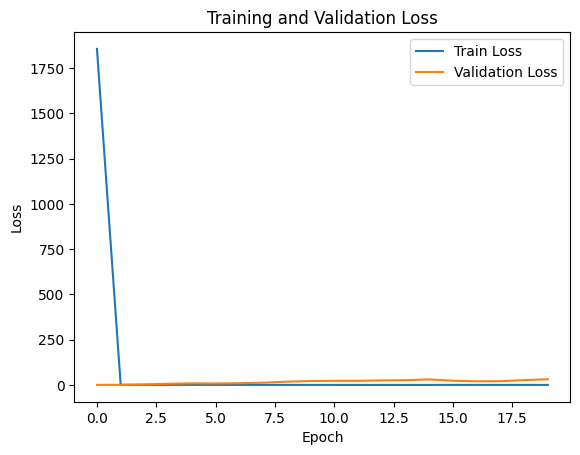

Training Accuracy: 0.84375
Validation Accuracy: 0.8125


In [32]:
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

tf.random.set_seed(1234)
np.random.seed(1234)

# Initialize model
model_tf = tf.keras.Sequential()

# Add convolutional layer
model_tf.add(layers.Conv2D(filters=12, kernel_size=(4, 4), strides=(1, 1), padding='same', 
                           data_format='channels_last', activation='relu', name='conv_1', 
                           input_shape=(224, 224, 3)))

# Add max pooling layer 
model_tf.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Add dropout layer
model_tf.add(layers.Dropout(rate=0.3))

# Add a flattening layer
model_tf.add(layers.Flatten())

# Add the classification layer
model_tf.add(layers.Dense(1, activation='sigmoid'))

# build and compile model
model_tf.build(input_shape=(None, 224, 224, 3))
model_tf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy']) 

# print model_tf summary
### YOUR CODE HERE ###
model_tf.summary()

# train model_tf on (X_train, y_train) data
### YOUR CODE HERE ###
history = model_tf.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), verbose=1)

# plot loss curves
### YOUR CODE HERE ###
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# evaluate the accuracy of model_tf on (X_train, y_train) and (X_val, y_val)
### YOUR CODE HERE ###
train_accuracy = model_tf.evaluate(X_train, y_train, verbose=0)[1]
val_accuracy = model_tf.evaluate(X_val, y_val, verbose=0)[1]
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

How many parameters does *model_tf* have? [YOUR ANSWER HERE]
151,117

Comment on *model_tf* accuracy on training vs. validation data: [YOUR ANSWER HERE]

The model's training accuracy is 84.38%, while the validation accuracy is 81.25%. This slight difference between training and validation accuracies suggests that the model is generalizing fairly well to new data without significant overfitting. The validation accuracy being close to the training accuracy indicates that the model has learned patterns in the data that generalize to unseen examples.

However, there is still a small gap, which may indicate that there is some degree of overfitting, but it's not severe. Further improvements in generalization could potentially be achieved with more data, fine-tuning hyperparameters, or additional regularization techniques if higher accuracy is desired.

#### <span style="color:chocolate"> Exercise 6 (20 points) </span>

1. Fine-tune the number of hidden layers and the hyperparameters of *model_tf* to determine the setup that yields the most optimal generalization performance. Feel free to explore various model configurations/hyperparameter values.

2. How many parameters does your fine-tuned model have?

3. Evaluate the accuracy of the fine-tuned model on (X_train, y_train) and (X_val, y_val) data. Comment on model performance on training vs. validation datasets.  Is there an improvement compared to the non-fine-tuned version of the model (Exercise 5)?

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     6,422,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,515,905 (24.86 MB)

 Trainable params: 6,515,905 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5923 - loss: 54.0728 - val_accuracy: 0.5312 - val_loss: 5.9219
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 440ms/step - accuracy: 0.7377 - loss: 4.3366 - val_accuracy: 0.7812 - val_loss: 2.0731
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 437ms/step - accuracy: 0.8302 - loss: 1.0399 - val_accuracy: 0.7812 - val_loss: 1.2403
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 425ms/step - accuracy: 0.8361 - loss: 0.5829 - val_accuracy: 0.8438 - val_loss: 0.9867
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 572ms/step - accuracy: 0.9049 - loss: 0.2000 - val_accuracy: 0.8438 - val_loss: 0.9920
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 598ms/step - accuracy: 0.9532 - loss: 0.1218 - val_accuracy: 0.8125 - val_loss: 0.8770
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 577ms/step - accuracy: 0.9371 - loss: 0.1086 - val_accuracy: 0.8438 - val_loss: 0.9533
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 599ms/step - accuracy: 0.9653 - loss: 0.0921 - val_accuracy: 0.8750 - val_loss: 0

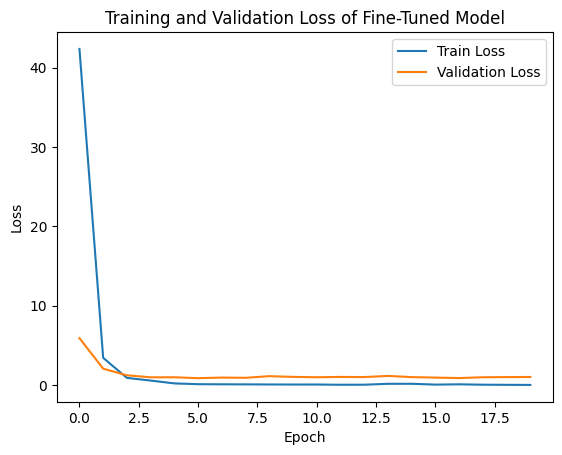

Training Accuracy (Fine-Tuned): 0.9947916865348816
Validation Accuracy (Fine-Tuned): 0.84375


In [33]:
### YOUR CODE HERE ###
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
tf.random.set_seed(1234)
np.random.seed(1234)

# Initialize the fine-tuned model
fine_tuned_model = tf.keras.Sequential()

# Add more convolutional layers and adjust hyperparameters
fine_tuned_model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', 
                                   activation='relu', input_shape=(224, 224, 3)))
fine_tuned_model.add(layers.MaxPooling2D(pool_size=(2, 2)))

fine_tuned_model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', 
                                   activation='relu'))
fine_tuned_model.add(layers.MaxPooling2D(pool_size=(2, 2)))

fine_tuned_model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', 
                                   activation='relu'))
fine_tuned_model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Increase the dropout rate for regularization
fine_tuned_model.add(layers.Dropout(rate=0.4))

# Add a flattening layer and a dense layer with more neurons for better representation
fine_tuned_model.add(layers.Flatten())
fine_tuned_model.add(layers.Dense(64, activation='relu'))

# Add the final classification layer
fine_tuned_model.add(layers.Dense(1, activation='sigmoid'))

# Compile the fine-tuned model with a lower learning rate for finer updates
fine_tuned_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                         loss=tf.keras.losses.BinaryCrossentropy(),
                         metrics=['accuracy'])

# Print the fine-tuned model summary to see the number of parameters
fine_tuned_model.summary()

# Train the fine-tuned model
history = fine_tuned_model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), verbose=1)

# Plot loss curves
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss of Fine-Tuned Model')
plt.legend()
plt.show()

# Evaluate the accuracy of the fine-tuned model on training and validation data
train_accuracy = fine_tuned_model.evaluate(X_train, y_train, verbose=0)[1]
val_accuracy = fine_tuned_model.evaluate(X_val, y_val, verbose=0)[1]
print("Training Accuracy (Fine-Tuned):", train_accuracy)
print("Validation Accuracy (Fine-Tuned):", val_accuracy)

How many parameters does your fine-tuned model have? [YOUR ANSWER HERE]

6,515,905

Comment on accuracy of the fine-tuned model on training vs. validation performance. Is there an improvement over the non-fine-tuned version? [YOUR ANSWER HERE]

The fine-tuned model shows a much higher training accuracy compared to the non-fine-tuned version, indicating that it has learned the training data very well. However, the validation accuracy did not improve significantly (from 81.25% in the non-fine-tuned model to 84.38% in the fine-tuned model). This slight improvement in validation accuracy suggests that the model has a better representation capacity but may be slightly overfitting the training data.

---
### Step 6: Evaluation

#### <span style="color:chocolate"> Exercise 7 (10 points) </span>

You will now use the test data to evaluate the performance (accuracy) of your fine-tuned model on unseen data. Does your model generalize well?

In [34]:
### YOUR CODE HERE ###
test_accuracy = fine_tuned_model.evaluate(X_test, y_test, verbose=0)[1]
print("Test Accuracy (Fine-Tuned):", test_accuracy)

# Interpretation
if test_accuracy > 0.8:  # Example threshold for good generalization
    print("The fine-tuned model generalizes well to the test data.")
else:
    print("The fine-tuned model may not generalize well to the test data.")

Test Accuracy (Fine-Tuned): 0.78125
The fine-tuned model may not generalize well to the test data.


Does your model generalize well? [YOUR ANSWER HERE]

The fine-tuned model may not generalize well to the test data.